This is an attempt to use the example sk time in the other notebook for a forecasting project

### Libraries

In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm # for example data

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster # for baseline model

%matplotlib inline
from sktime.utils.plotting import plot_series
import seaborn as sns
sns.set(rc={'figure.figsize':(20,16)})

### Get data

In [3]:
# Pull data from stats models for example
df = sm.datasets.macrodata.load_pandas()['data']

# Making a single year/qtr field 
df['q_date'] = df.apply(lambda x: str(int(x['year'])) + '-Q' + str(int(x['quarter'])), axis=1)
# Specifying this as this is a time series and that the frequency is quarterly
df['date'] = pd.PeriodIndex(df['q_date'], freq='Q').to_timestamp()
# Using this as the index
df = df.set_index('date').to_period("Q")

# View df
df

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,q_date
date,,,,,,,,,,,,,,,
1959Q1,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00,1959-Q1
1959Q2,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74,1959-Q2
1959Q3,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09,1959-Q3
1959Q4,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06,1959-Q4
1960Q1,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19,1960-Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008Q3,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33,2008-Q3
2008Q4,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91,2008-Q4
2009Q1,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71,2009-Q1


### EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 203 entries, 1959Q1 to 2009Q3
Freq: Q-DEC
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      203 non-null    float64
 1   quarter   203 non-null    float64
 2   realgdp   203 non-null    float64
 3   realcons  203 non-null    float64
 4   realinv   203 non-null    float64
 5   realgovt  203 non-null    float64
 6   realdpi   203 non-null    float64
 7   cpi       203 non-null    float64
 8   m1        203 non-null    float64
 9   tbilrate  203 non-null    float64
 10  unemp     203 non-null    float64
 11  pop       203 non-null    float64
 12  infl      203 non-null    float64
 13  realint   203 non-null    float64
 14  q_date    203 non-null    object 
dtypes: float64(14), object(1)
memory usage: 25.4+ KB


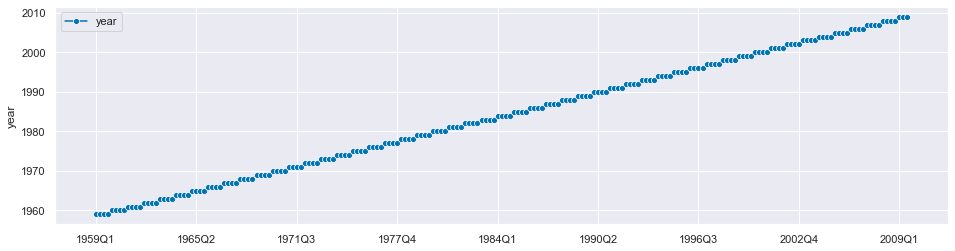

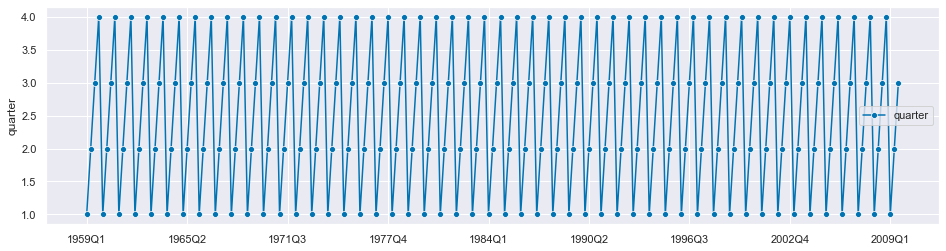

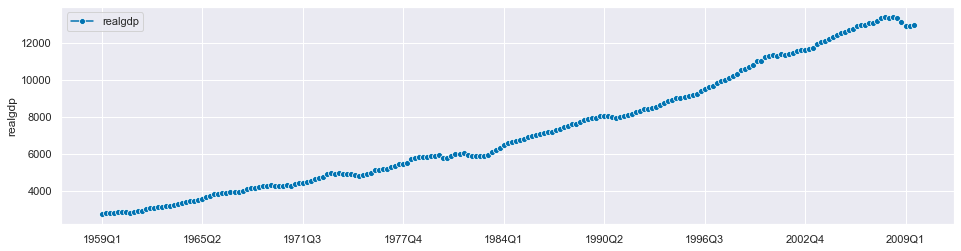

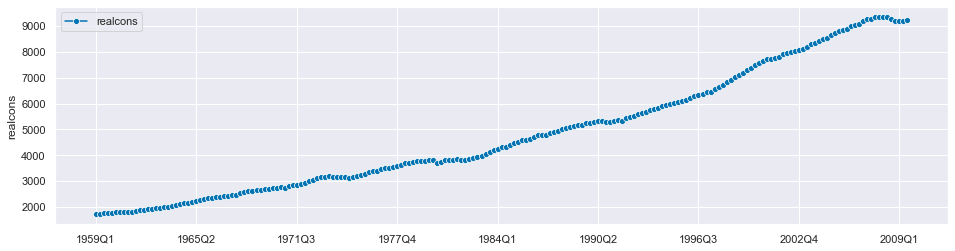

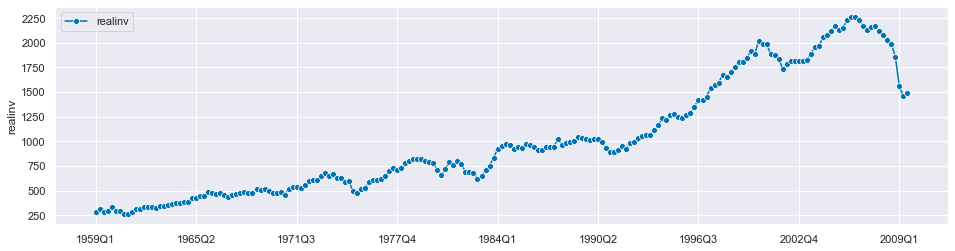

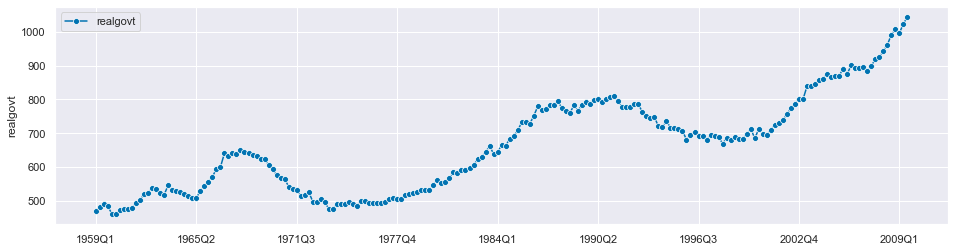

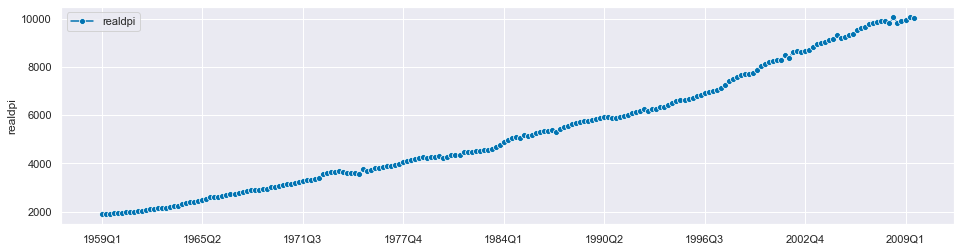

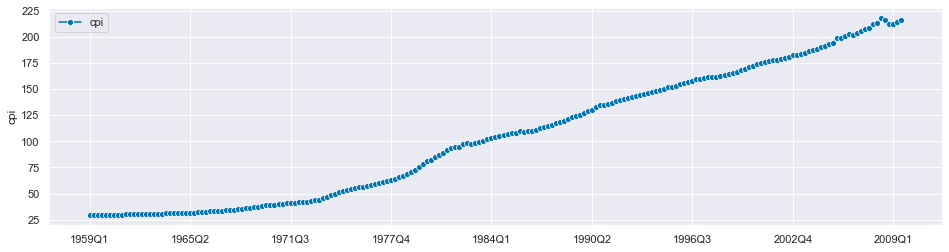

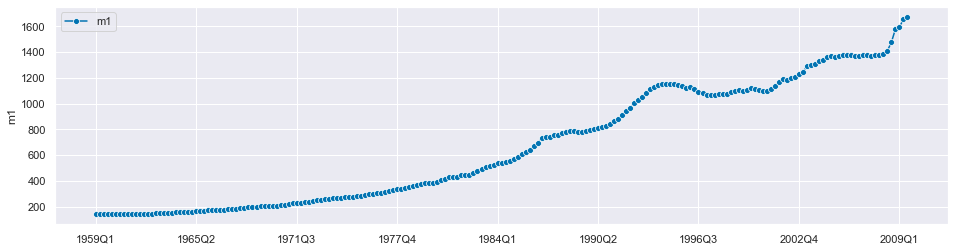

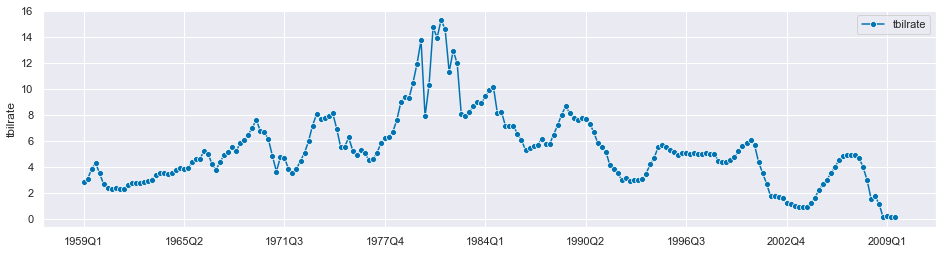

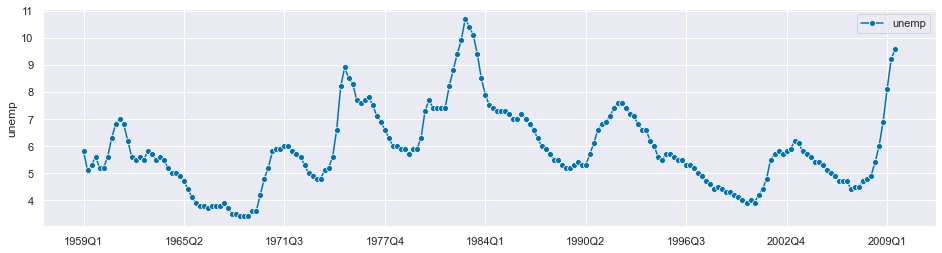

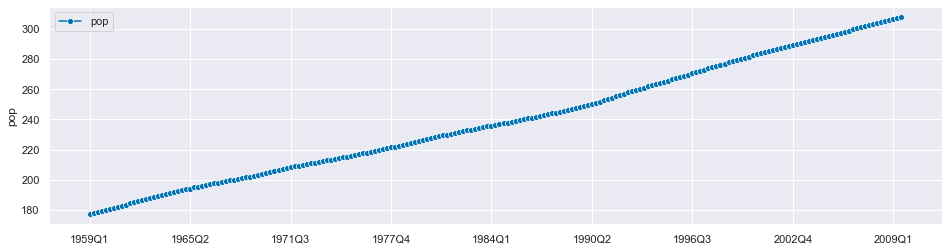

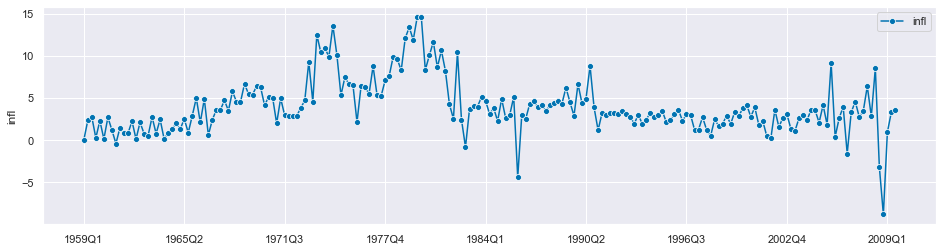

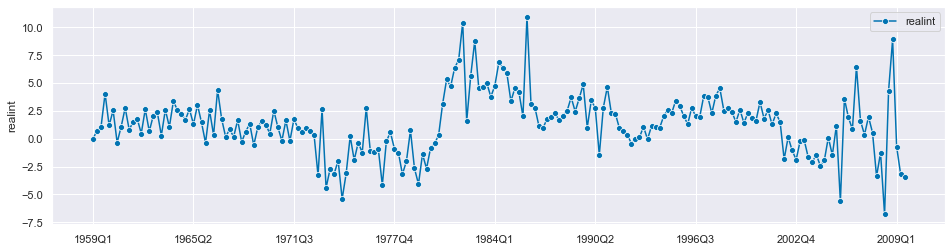

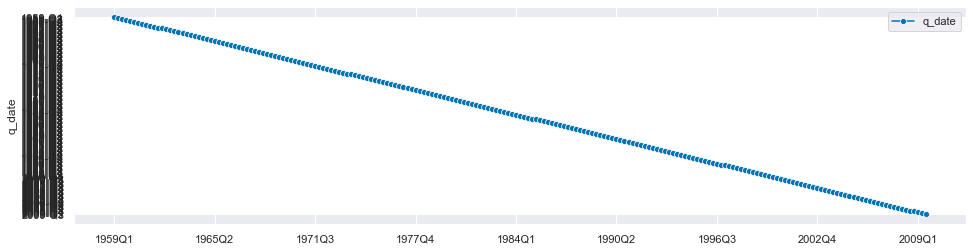

In [7]:
for i in list(df.columns):
    plot_series(df[i], labels=[f"{i}"])

#### Correlations

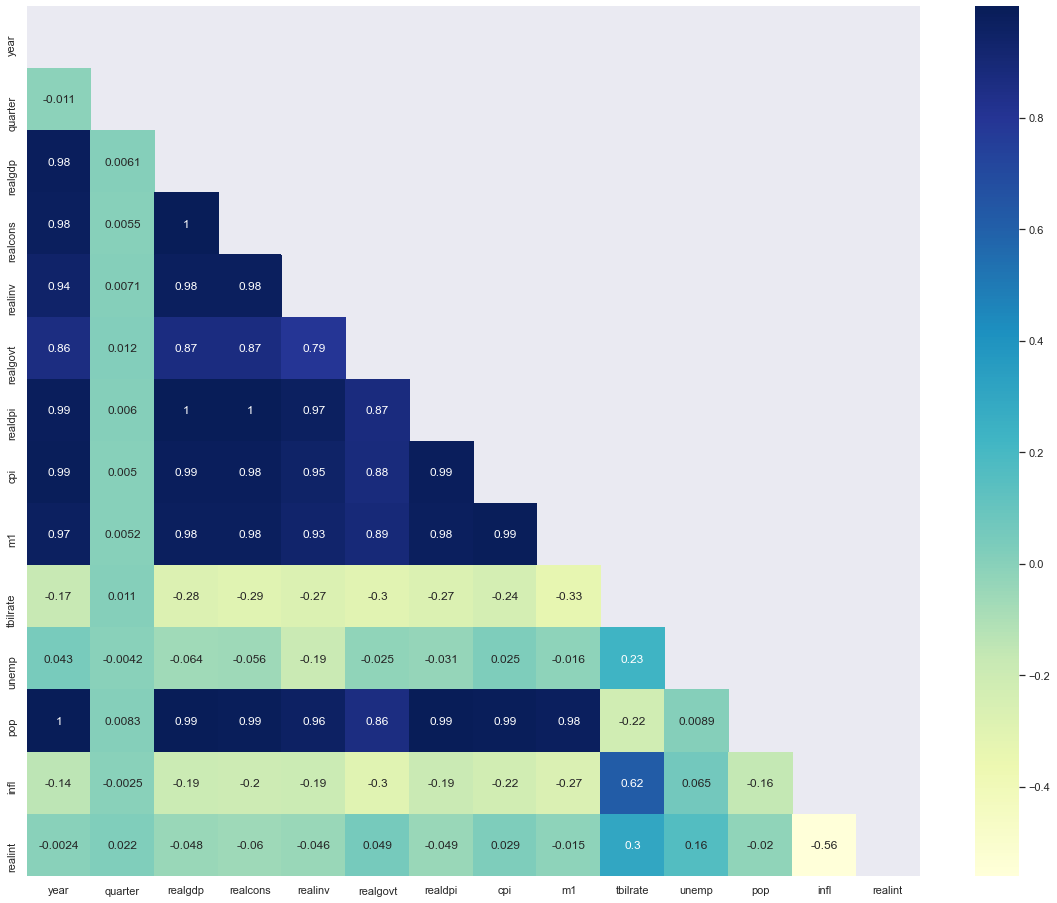

In [10]:
# creating mask
mask = np.triu(np.ones_like(df.corr()))
 
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, mask=mask)